In [21]:
import numpy as np
import matplotlib.pyplot as plt
import random

# AHL Parameters
D = 0.01  # Diffusion coefficient
k = 0.01  # Chemotaxis coefficient
dt = 0.1  # Time step
T = 1.0  # Total simulation time
N = 100  # Number of grid points in each dimension
h = 10 / N  # Grid spacing
decay = 0.001  # Decay rate

# Cell Parameters
I = 0.1  # lateral inhibition factor
E = 0.1  # AHL enhancement factor
B = 0.01 # background signal


In [22]:
# laplacian
def laplacian(data, D, h, dt):

    lapl = np.roll(data, 1, axis=0) + np.roll(data, -1, axis=0) + np.roll(data, 1, axis=1) + np.roll(data, -1, axis=1) - 4 * data
    lapl /= h**2
    data += D * lapl * dt
    return data

In [23]:
# cell grow and gain initial expression
def grow(cell, CdiA, GFP, AHL, CI, LuxR, possibility, B):

    N = len(cell)
    new_cell = cell.copy()
    new_CdiA = CdiA.copy()
    new_GFP = GFP.copy()
    new_AHL = AHL.copy()
    new_CI = CI.copy()
    new_LuxR = LuxR.copy()

    for i in range(1,N-1):
        for j in range(1,N-1):
            if cell[i,j] == 0:
                neighbors= [cell[i-1,j], cell[i,j-1], cell[i+1,j], cell[i,j+1], cell[i-1,j-1], cell[i+1,j+1], cell[i-1,j+1], cell[i+1,j-1]]
                if (sum(neighbors)!=0) and (random.random() < possibility * sum(neighbors)):

                    # generate a new cell
                    new_cell[i,j] = 1

                    # inherit CdiA, GFP, CI from a random parent
                    neighbor_positions = [(i-1,j), (i,j-1), (i+1,j), (i,j+1), (i-1,j-1), (i+1,j+1), (i-1,j+1), (i+1,j-1)]
                    new_CdiA[i,j] = 0
                    while new_CdiA[i,j] == 0:
                        ref_i, ref_j = random.choice(neighbor_positions)
                        new_CdiA[i,j] = CdiA[ref_i, ref_j]
                        new_GFP[i,j] = GFP[ref_i, ref_j]
                        new_CI[i,j] = CI[ref_i, ref_j]
                        new_LuxR[i,j] = LuxR[ref_i, ref_j]
                        new_AHL[i,j] = AHL[ref_i, ref_j]

                    
    return new_cell, new_CdiA, new_GFP, new_AHL, new_CI, new_LuxR
    

In [24]:
# CI repress GFP and CdiA
def CI_repress(CI, GFP, CdiA, beta_GFP, beta_CdiA, K_CdiA, K_GFP, decay_GFP, decay_CdiA):
    
    GFP -= decay_GFP * GFP
    CdiA -= decay_CdiA * CdiA
    GFP += beta_GFP / (1+ (CI / K_GFP)**2)
    CdiA += beta_CdiA / (1+ (CI / K_CdiA)**2)
    
    return GFP, CdiA

In [25]:
# cell receive CdiA 
def receive_CdiA(CdiA, LuxR, ratio, decay_LuxR):

    LuxR -= decay_LuxR * LuxR
    group1 = np.roll(CdiA, 1, axis=0)+np.roll(CdiA, -1, axis=0)+np.roll(CdiA, 1, axis=1)+np.roll(CdiA, -1, axis=1)
    group2 = np.roll(np.roll(CdiA, 1, axis=0), 1, axis=1)+np.roll(np.roll(CdiA, -1, axis=0), -1, axis=1)+np.roll(np.roll(CdiA, 1, axis=0), -1, axis=1)+np.roll(np.roll(CdiA, -1, axis=0), 1, axis=1)
    LuxR += ratio * (group1 + group2)

    return LuxR

In [104]:
# LuxR and AHL combines to activate AHL and CI expression
def LuxR_AHL_activate(LuxR, AHL, CI, beta_CI, K_CI, beta_AHL, K_AHL, decay_CI, decay_AHL):
    
    CI -= decay_CI * CI
    AHL -= decay_AHL * AHL

    AHL_LuxR2 = AHL * LuxR**2
    
    CI += beta_CI * AHL_LuxR2 / (K_CI + AHL_LuxR2)
    AHL += beta_AHL * AHL_LuxR2 / (K_AHL + AHL_LuxR2)
    
    return AHL, CI

In [27]:
# no cell, no GFP, CI, CdiA, LuxR
def no_cell(cell, GFP, CI, CdiA, LuxR):

    GFP = GFP * cell
    CI = CI * cell
    CdiA = CdiA * cell
    LuxR = LuxR * cell
    
    return GFP, CI, CdiA, LuxR

In [105]:
# Initialize the grid
x = np.linspace(0, 1, N)
X, Y = np.meshgrid(x, x)

cell = np.zeros((N, N))  # Cells position
CdiA = np.zeros((N, N))  # CdiA expression
LuxR = np.zeros((N, N))  # LuxR received by each cell
AHL = np.zeros((N, N))  # AHL concentration
LA = LuxR * AHL  # LuxR*AHL
CI =  np.zeros((N, N))  # CI expression
GFP =  np.zeros((N, N))  # GFP expression

cell[50,50]=1
GFP[50,50]=CdiA[50,50]=1
LuxR[50,50]=1
AHL[50,50]=1
CI[50,50]=1

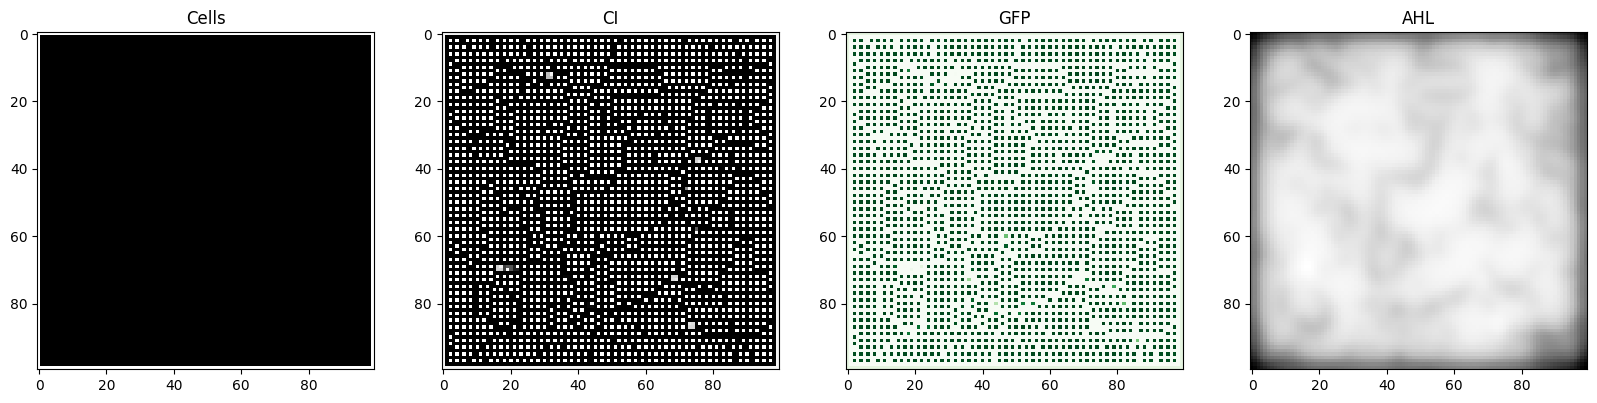

In [146]:
# new simulation

for step in range(100):

    # cell grow, gain GFP and cdiA expression, and secret background AHL
    cell, CdiA, GFP, AHL, CI, LuxR = grow(cell, CdiA, GFP, AHL, CI, LuxR, possibility=0.3, B=0.001)

    # no cell, no GFP, CI, CdiA, LuxR
    GFP, CI, CdiA, LuxR = no_cell(cell, GFP, CI, CdiA, LuxR)

    # CI repress GFP and CdiA expression
    GFP, CdiA = CI_repress(CI, GFP, CdiA, beta_GFP=0.1, beta_CdiA=0.1, K_CdiA=1, K_GFP=1, decay_GFP=0.1, decay_CdiA=0.1)

    # cell receive CdiA signal from neighbor and convert to LuxR signal
    LuxR = receive_CdiA(CdiA, LuxR, ratio=1, decay_LuxR=0.1)

    # LuxR and AHL combines to activate AHL and CI expression
    AHL, CI = LuxR_AHL_activate(LuxR, AHL, CI, beta_CI=10, K_CI=1, beta_AHL=10, K_AHL=1, decay_CI=0.1, decay_AHL=0.1)

    # AHL diffusion
    for dif in range(10):
        AHL = laplacian(AHL, D=0.02, h=10/N, dt=0.1)

# plotting Cells, CdiA, GFP, AHL
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax[0].imshow(cell, cmap='Greys')
ax[1].imshow(CI, cmap='Greys')
ax[2].imshow(GFP, cmap='Greens')
ax[3].imshow(AHL, cmap='Greys')
ax[0].set_title('Cells')
ax[1].set_title('CI')
ax[2].set_title('GFP')
ax[3].set_title('AHL')
plt.show()